# WixQA

## Knowledge Base

In [2]:
from datasets import load_dataset

ds = load_dataset("Wix/WixQA", "wix_kb_corpus")

In [3]:
ds["train"][0]

{'id': '860475a2cbc65c226ecf08729d0430584e46f35f23a3e10bb5500c2c4ad09168',
 'url': 'https://support.wix.com/en/article/wix-events-about-the-event-details-and-registration-form-pages',
 'contents': 'Wix Events: About the Event Details and Registration Form Pages\nGuests visiting your site view the events you offer on the Events List page. From there they can learn more on the Events Details page (if enabled) and \xa0complete the booking on the Registration Form Page.\xa0You can customize how these pages look to suit your events.Tips:\nCustomizations you make to the Events Details page and the Registration Form page (e.g. changing colors and fonts, hiding page elements) affect these page for all events. \xa0 If your site only has events without tickets, you have the option of disabling the Event Details Page.Events Details PageSite visitors who click to register for an event are first directed to the Event Details page (unless you hid the page). There, guests can receive more complete in

Content length statistics:
Min length: 26
Max length: 51119
Mean length: 2270.12
Median length: 1205

Article type distribution:
article: 4109 (66.05%)
feature_request: 2049 (32.94%)
known_issue: 63 (1.01%)

Title length statistics:
Min length: 7
Max length: 141
Mean length: 52.38
Median length: 51


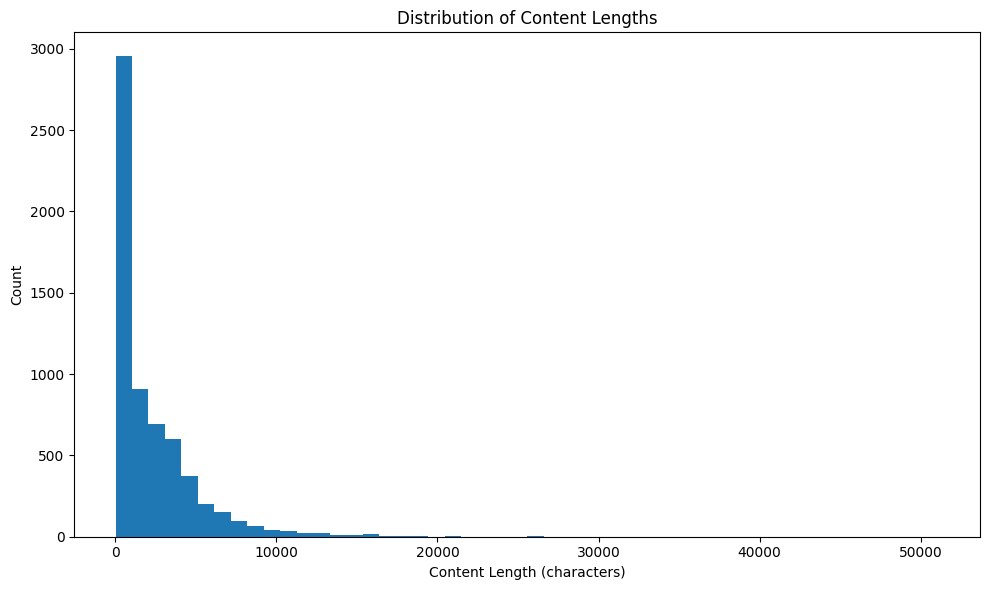

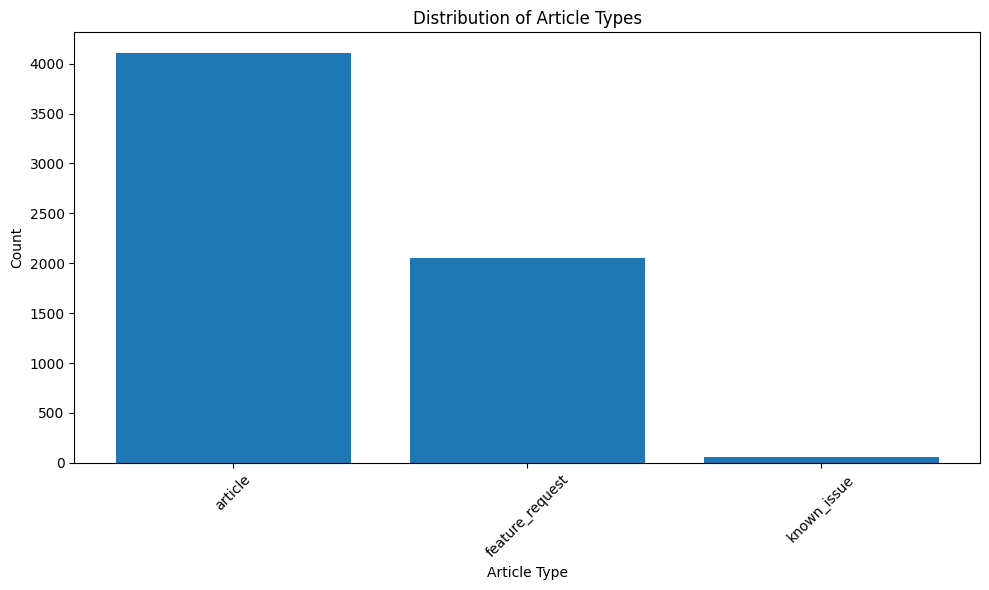

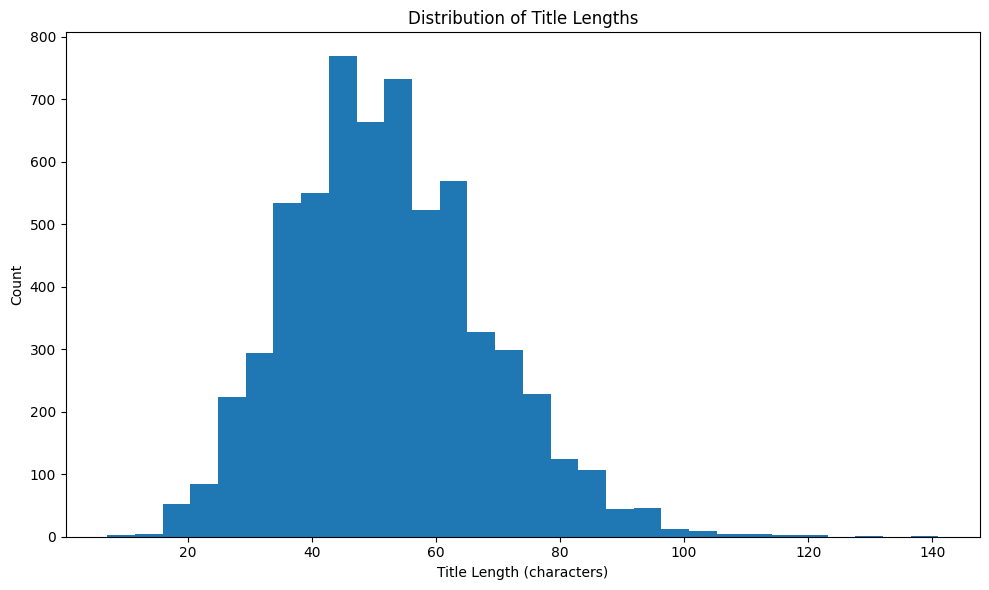

In [4]:
# Analyze the distribution of content lengths and article types
import collections
import matplotlib.pyplot as plt

# Calculate content lengths
content_lengths = [len(item["contents"]) for item in ds["train"]]

# Get article types and titles
article_types = [item["article_type"] for item in ds["train"]]
titles = [item["title"] for item in ds["train"]]

# Count article types
article_type_counts = collections.Counter(article_types)

# Count title lengths
title_lengths = [len(title) for title in titles]

# Print statistics about content length
print("Content length statistics:")
print(f"Min length: {min(content_lengths)}")
print(f"Max length: {max(content_lengths)}")
print(f"Mean length: {sum(content_lengths)/len(content_lengths):.2f}")
print(f"Median length: {sorted(content_lengths)[len(content_lengths)//2]}")

# Print article type distribution
print("\nArticle type distribution:")
for article_type, count in article_type_counts.most_common():
    print(f"{article_type}: {count} ({count/len(article_types)*100:.2f}%)")

# Print title length statistics
print("\nTitle length statistics:")
print(f"Min length: {min(title_lengths)}")
print(f"Max length: {max(title_lengths)}")
print(f"Mean length: {sum(title_lengths)/len(title_lengths):.2f}")
print(f"Median length: {sorted(title_lengths)[len(title_lengths)//2]}")

# Plot content length distribution
plt.figure(figsize=(10, 6))
plt.hist(content_lengths, bins=50)
plt.xlabel('Content Length (characters)')
plt.ylabel('Count')
plt.title('Distribution of Content Lengths')
plt.tight_layout()
plt.show()

# Plot article type distribution
plt.figure(figsize=(10, 6))
plt.bar(article_type_counts.keys(), article_type_counts.values())
plt.xlabel('Article Type')
plt.ylabel('Count')
plt.title('Distribution of Article Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot title length distribution
plt.figure(figsize=(10, 6))
plt.hist(title_lengths, bins=30)
plt.xlabel('Title Length (characters)')
plt.ylabel('Count')
plt.title('Distribution of Title Lengths')
plt.tight_layout()
plt.show()


## Questions with Expert Answers

In [5]:
questions = load_dataset("Wix/WixQA", "wixqa_expertwritten")

In [6]:
questions["train"][0]

{'question': 'Can I start accepting payments on my site while my Wix Payments account is still under verification?',
 'answer': 'You can start accepting payments on your site using [Wix Payments](https://support.wix.com/en/article/about-wix-payments) almost immediately. However, we need to verify your identity before your account can be fully activated.',
 'article_ids': ['49d9e88fadbf11fa4e685c847590078ff9394c2fe7566094f504f53ca4aca465']}

Questions with 1 article_ids: 148 (74.00%)
Questions with 2 article_ids: 46 (23.00%)
Questions with 3 article_ids: 6 (3.00%)


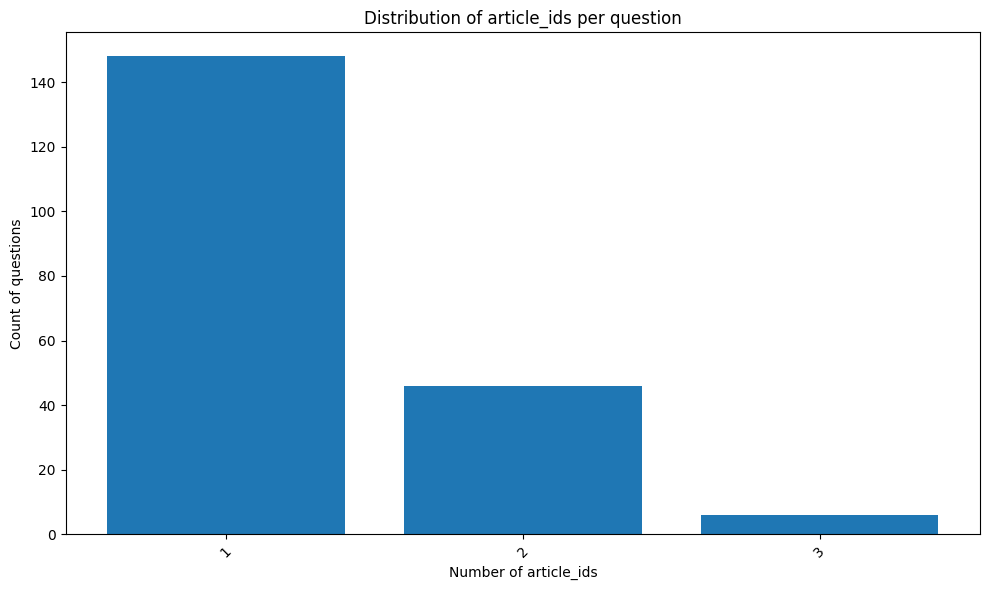

In [7]:
# Count the distribution of article_ids per question
import collections
import matplotlib.pyplot as plt

# Get the number of article_ids for each question
article_counts = [len(q["article_ids"]) for q in questions["train"]]

# Count the frequency of each number
count_distribution = collections.Counter(article_counts)

# Sort by number of article_ids
sorted_distribution = sorted(count_distribution.items())

# Print the distribution
for num_articles, count in sorted_distribution:
    print(f"Questions with {num_articles} article_ids: {count} ({count/len(article_counts)*100:.2f}%)")

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar([str(k) for k, v in sorted_distribution], [v for k, v in sorted_distribution])
plt.xlabel('Number of article_ids')
plt.ylabel('Count of questions')
plt.title('Distribution of article_ids per question')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cleaning

Hypothesis: Remove short documents.

Conclusion: This will remove too many questions (9/200) = 4.5% of the questions dataset.

In [10]:
# Identify documents with fewer than 100 tokens
short_docs = [item["id"] for item in ds["train"] if len(item["contents"].split()) < 100]

# Check if any questions reference these short documents
questions_affected = [q for q in questions["train"] if any(doc_id in short_docs for doc_id in q["article_ids"])]
print(f"Questions affected if we removed short documents: {len(questions_affected)}")

Questions affected if we removed short documents: 9


Hypothesis: Chunk long documents and duplicate ids. However, this complicates retrieval evaluation.

Quick Solution: Duplicate the id and just count it a success if the id is included. It's hard to say if this makes it easier, since you also duplicate the other documents so you are retrieving from a larger set.

More Advanced Solution: Chunk and then use the Transformation Agent to assess if the answer is contained in the chunk. If no, remove the id from that chunk.